In [32]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torchvision.io import read_image

In [2]:
def create_metadata(output_path, metadata_filename):
    inputs, outputs = [], []
    for image in tqdm(list(os.listdir(output_path)), total=len(list(os.listdir(output_path)))):
        filename = image.split(".")[0].rstrip("_segmentation") + ".jpg"
        inputs.append(filename)
        outputs.append(image)
    df = pd.DataFrame({
        "image": inputs,
        "GT": outputs
    })
    df.to_csv(metadata_filename)
    return True

In [33]:
outputs = "./data/ISIC2018_Task1_Training_GroundTruth/"
inputs = "./data/ISIC2018_Task1-2_Training_Input/"
# create_metadata(outputs, "metadata.csv")

In [4]:
read_image(outputs + os.listdir(outputs)[np.random.randint(0, len(os.listdir(outputs)) - 1)])

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

Функция удаления волос, с помощью с OpenCV

In [5]:
def hair_remove(image):
    image =np.array(image)
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    return final_image

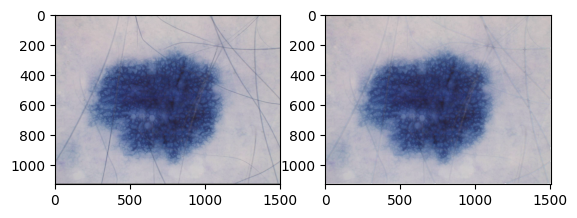

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# img = Image.open(inputs + os.listdir(inputs)[2]).convert("RGB")
img = cv2.imread(inputs + os.listdir(inputs)[16], cv2.IMREAD_COLOR)
rmv = hair_remove(img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(rmv)

In [36]:
import shutil


try:
    os.mkdir("./data/train/inputs")
    os.mkdir("./data/train/ground_truth")
    os.mkdir("./data/test/inputs")
    os.mkdir("./data/test/ground_truth")
    print("All dirs created!")
except FileExistsError:
    print("Dirs are already exist!")
    pass

df = pd.read_csv("./meta/meta_train.csv")
df = df[["image", "GT"]]

for i, row in tqdm(df.iterrows(), total=len(df)):
    x, y = row
    src = inputs + x
    dst = "./data/train/inputs/" + x
    shutil.copyfile(src, dst)
    src = outputs + y
    dst = "./data/train/ground_truth/" + y
    shutil.copyfile(src, dst)

df = pd.read_csv("./meta/meta_val.csv")
df = df[["image", "GT"]]
for i, row in tqdm(df.iterrows(), total=len(df)):
    x, y = row
    src = inputs + x
    dst = "./data/test/inputs/" + x
    shutil.copyfile(src, dst)
    src = outputs + y
    dst = "./data/test/ground_truth/" + y
    shutil.copyfile(src, dst)

All dirs created!


  0%|          | 0/1945 [00:00<?, ?it/s]

  0%|          | 0/649 [00:00<?, ?it/s]

In [57]:
import segmentation_models_pytorch as smp
import torch

# lets assume we have multilabel prediction for 3 classes
output = torch.tensor([
    [
        [0,0,0,0,0],
        [0,0,1,1,0],
        [0,1,1,1,0],
        [0,1,1,1,1],
        [0,0,0,0,0]
    ],
    [
        [0,1,0,0,0],
        [0,1,1,1,1],
        [0,1,1,1,0],
        [0,1,1,1,1],
        [0,0,0,0,0]
    ]
])
target = torch.tensor([
    [
        [0,0,0,0,0],
        [0,1,1,1,0],
        [0,1,1,1,0],
        [0,1,1,1,0],
        [0,0,0,0,0]
    ],
    [
        [0,0,1,0,0],
        [0,1,1,1,0],
        [1,1,1,1,1],
        [0,1,1,1,0],
        [0,0,1,0,0]
    ]
])

# first compute statistics for true positives, false positives, false negative and
# true negative "pixels"
tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='binary', threshold=0.5)

# then compute metrics with required reduction (see metric docs)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

In [85]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2

C:\Users\nesemenpolkov\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\nesemenpolkov\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according 

Описание архитектуры VGG (backbone) + FCN16 (segmentation-head)

In [109]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

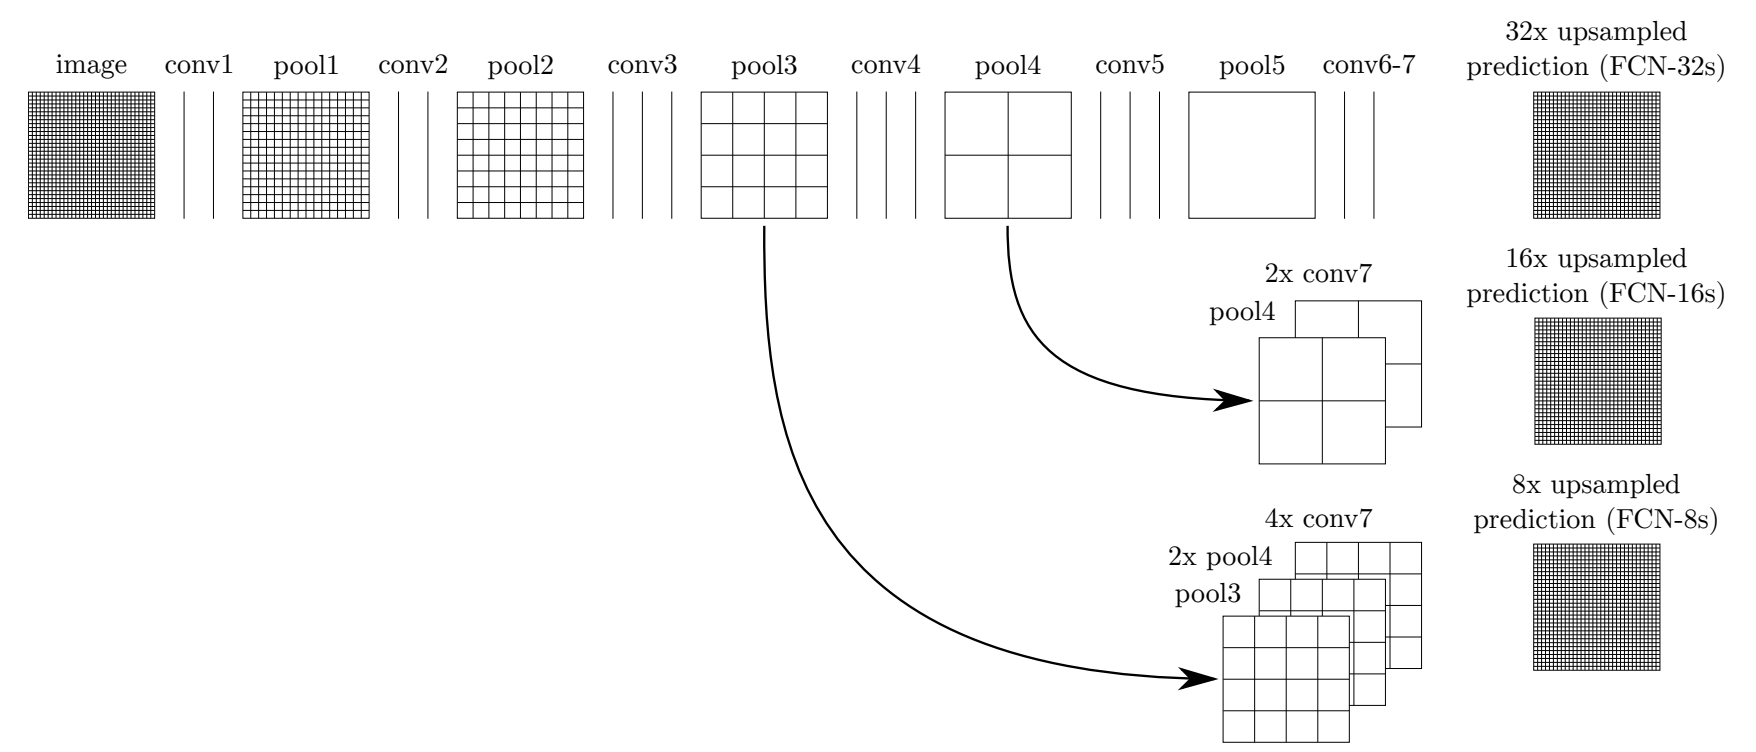

In [107]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        
        self.features = vggModel.features

        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()
        
        for i, layer in enumerate(self.features.children()):
            x = layer(x) 
            
            if i in self.layerIndices:
                outputs.append(x)
                
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs

In [108]:
vgg = models.vgg16(pretrained=True)

In [112]:
backbone = vgg.features
pool4 = vgg.features[0:24]
inp = torch.randn(1,3,224,224)
out = backbone(inp)
pool4_out = pool4(inp)
out.shape, pool4_out.shape

(torch.Size([1, 512, 7, 7]), torch.Size([1, 512, 14, 14]))

In [131]:
upsample = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
outx2 = upsample(out)
outx2.shape

torch.Size([1, 512, 14, 14])

In [138]:
upsample_2 = nn.ConvTranspose2d(512, 512, kernel_size=5, stride=16, padding=0, dilation=3, output_padding=3)
result = upsample_2(outx2 + pool4_out)
result.shape

torch.Size([1, 512, 224, 224])